In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('processeddataset/processed_paySim.csv')
df.head()

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df['transaction_velocity_org'] = df.groupby('nameOrig')['step'].diff().fillna(0)
df['amount_velocity_org'] = df.groupby('nameOrig')['amount'].diff().fillna(0)

# Risk indicators from EDA insights
df['high_risk_hour'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['high_risk_type'] = df['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)
df['large_amount_flag'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)

# Balance-based risk indicators
df['zero_balance_orig'] = (df['oldbalanceOrg'] == 0).astype(int)
df['zero_balance_dest'] = (df['oldbalanceDest'] == 0).astype(int)
df['balance_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['balance_ratio_dest'] = df['amount'] / (df['oldbalanceDest'] + 1)

# Aggregated customer behavior
customer_features = df.groupby('nameOrig').agg({
    'amount': ['mean', 'std', 'count'],
    'step': ['min', 'max'],
    'isFraud': 'mean'
}).fillna(0)

customer_features.columns = ['cust_avg_amt', 'cust_std_amt', 'cust_txn_count', 
                            'cust_first_txn', 'cust_last_txn', 'cust_hist_fraud_rate']

df = df.merge(customer_features, left_on='nameOrig', right_index=True, how='left')
df.head()

In [ ]:
df.to_csv('processeddataset/processed_cust_features.csv', index=False)

In [ ]:
df.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:
import mlflow
import mlflow.sklearn

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [ ]:
feature_columns = [
'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
'hour', 'is_weekend', 'high_risk_hour', 'high_risk_type', 'large_amount_flag',
'zero_balance_orig', 'zero_balance_dest', 'balance_ratio_orig', 'balance_ratio_dest',
'cust_avg_amt', 'cust_std_amt', 'cust_txn_count'
]
X = df[feature_columns]
y = df['isFraud']

In [ ]:
new_df = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
'hour', 'is_weekend', 'high_risk_hour', 'high_risk_type', 'large_amount_flag',
'zero_balance_orig', 'zero_balance_dest', 'balance_ratio_orig', 'balance_ratio_dest',
'cust_avg_amt', 'cust_std_amt', 'cust_txn_count', 'isFraud']]
new_df.head()

In [ ]:
new_df['isFraud'].value_counts()

In [ ]:
new_df.to_csv('processeddataset/final_feature_paySim.csv', index=False)

In [ ]:
print("Original class distribution:", Counter(y))
print(f"Fraud rate: {y.mean():.4f} ({y.sum()} fraud cases out of {len(y)} total)")

In [ ]:
mlflow.set_experiment("Compare ROS vs RUS Strategies")

def evaluate_imbalance_strategies(X, y, feature_names):
        
    # Split the data - 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training set distribution: {Counter(y_train)}")
    print(f"Test set distribution: {Counter(y_test)}")
    
    # Define strategies to compare
    strategies = {
        'no_sampling': {
            'sampler': None,
            'name': 'No Sampling (Baseline)'
        },
        'RandomOverSampler': {
            'sampler': RandomOverSampler(
                random_state=42,
                sampling_strategy='auto' # Can adjust to 'minority' or specific ratio
            ),
            'name': 'RandomOverSampler'
        },
        'random_undersampling': {
            'sampler': RandomUnderSampler(
                random_state=42,
                sampling_strategy='auto'  # Can adjust ratio
            ),
            'name': 'Random UnderSampling'
        }
    }
    
    results = {}
    
    for strategy_name, strategy_config in strategies.items():
        print(f"\n{'='*50}")
        print(f"Testing strategy: {strategy_config['name']}")
        print(f"{'='*50}")
        
        with mlflow.start_run(run_name=strategy_config['name']):
            # Create pipeline
            if strategy_config['sampler'] is None:
                pipeline = RandomForestClassifier(
                    n_estimators=100,
                    random_state=42,
                    class_weight='balanced'  # Use class weights when no sampling
                )
                X_resampled = X_train
                y_resampled = y_train
            else:
                pipeline = Pipeline([
                    ('sampler', strategy_config['sampler']),
                    ('classifier', RandomForestClassifier(
                        n_estimators=100,
                        random_state=42,
                        class_weight=None  # No need for class weights when sampling
                    ))
                ])
            
            # Log strategy parameters
            mlflow.log_param("strategy", strategy_config['name'])
            mlflow.log_param("classifier", "RandomForest")
            mlflow.log_param("training_samples_before", len(X_train))
            mlflow.log_param("training_samples_after", len(X_resampled))
            mlflow.log_param("fraud_cases_before", y_train.sum())
            mlflow.log_param("fraud_cases_after", y_resampled.sum())
            
            print(f"Training set size after sampling: {len(X_resampled)}")
            print(f"Class distribution after sampling: {Counter(y_resampled)}")
            
            # Train model
            pipeline.fit(X_resampled, y_resampled)
            
            # Make predictions
            if strategy_config['sampler'] is None:
                y_pred = pipeline.predict(X_test)
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
            else:
                y_pred = pipeline.named_steps['classifier'].predict(X_test)
                y_pred_proba = pipeline.named_steps['classifier'].predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            classification_rep = classification_report(y_test, y_pred, output_dict=True)
            cm = confusion_matrix(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            # Extract key metrics
            precision_0 = classification_rep['0']['precision']
            recall_0 = classification_rep['0']['recall']
            f1_0 = classification_rep['0']['f1-score']
            
            precision_1 = classification_rep['1']['precision']
            recall_1 = classification_rep['1']['recall']
            f1_1 = classification_rep['1']['f1-score']
            
            accuracy = classification_rep['accuracy']
            
            # Business-oriented metrics
            tn, fp, fn, tp = cm.ravel()
            false_positive_rate = fp / (fp + tn)
            false_negative_rate = fn / (fn + tp)
            
            # Log metrics to MLflow
            mlflow.log_metric("test_accuracy", accuracy) # type: ignore
            mlflow.log_metric("test_roc_auc", roc_auc)
            mlflow.log_metric("fraud_precision", precision_1)
            mlflow.log_metric("fraud_recall", recall_1)
            mlflow.log_metric("fraud_f1", f1_1)
            mlflow.log_metric("non_fraud_precision", precision_0)
            mlflow.log_metric("non_fraud_recall", recall_0)
            mlflow.log_metric("non_fraud_f1", f1_0)
            mlflow.log_metric("false_positive_rate", false_positive_rate)
            mlflow.log_metric("false_negative_rate", false_negative_rate)
            mlflow.log_metric("true_positives", tp)
            mlflow.log_metric("false_positives", fp)
            mlflow.log_metric("true_negatives", tn)
            mlflow.log_metric("false_negatives", fn)
            
            # Log classification report as JSON
            mlflow.log_dict(classification_rep, "classification_report.json")
            
            # Log the model
            mlflow.sklearn.log_model(pipeline, f"model_{strategy_name}")
            
            # Store results
            results[strategy_name] = {
                'pipeline': pipeline,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'classification_report': classification_rep,
                'confusion_matrix': cm,
                'roc_auc': roc_auc,
                'resampled_distribution': Counter(y_resampled),
                'false_positive_rate': false_positive_rate,
                'false_negative_rate': false_negative_rate
            }
            
            # Print results
            print(f"\nResults for {strategy_config['name']}:")
            print(f"ROC-AUC: {roc_auc:.4f}")
            print(f"Fraud Precision: {precision_1:.4f}")
            print(f"Fraud Recall: {recall_1:.4f}")
            print(f"Fraud F1-Score: {f1_1:.4f}")
            print(f"False Positive Rate: {false_positive_rate:.4f}")
            print(f"False Negative Rate: {false_negative_rate:.4f}")
            print(f"Confusion Matrix:\n{cm}")
    
    return results, X_test, y_test

In [ ]:
results, X_test, y_test = evaluate_imbalance_strategies(X, y, feature_columns)

In [ ]:
def generate_comparison_report(results):
    """
    Generate a comprehensive comparison report of all strategies
    """
    comparison_data = []
    
    for strategy_name, result in results.items():
        cr = result['classification_report']
        comparison_data.append({
            'Strategy': strategy_name,
            'ROC-AUC': result['roc_auc'],
            'Accuracy': cr['accuracy'],
            'Fraud Precision': cr['1']['precision'],
            'Fraud Recall': cr['1']['recall'],
            'Fraud F1-Score': cr['1']['f1-score'],
            'Non-Fraud Precision': cr['0']['precision'],
            'Non-Fraud Recall': cr['0']['recall'],
            'False Positive Rate': result['false_positive_rate'],
            'False Negative Rate': result['false_negative_rate'],
            'Training Samples After': sum(result['resampled_distribution'].values())
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Fraud F1-Score', ascending=False)
    
    # print("\n" + "="*80)
    # print("COMPREHENSIVE STRATEGY COMPARISON")
    # print("="*80)
    # print(comparison_df.round(4))
    
    return comparison_df

In [ ]:
comparison_df = generate_comparison_report(results)
comparison_df.head()

In [ ]:
comparison_df.to_csv('processeddataset/model_strategy_comparison.csv', index=False)

mlflow experiment tracking

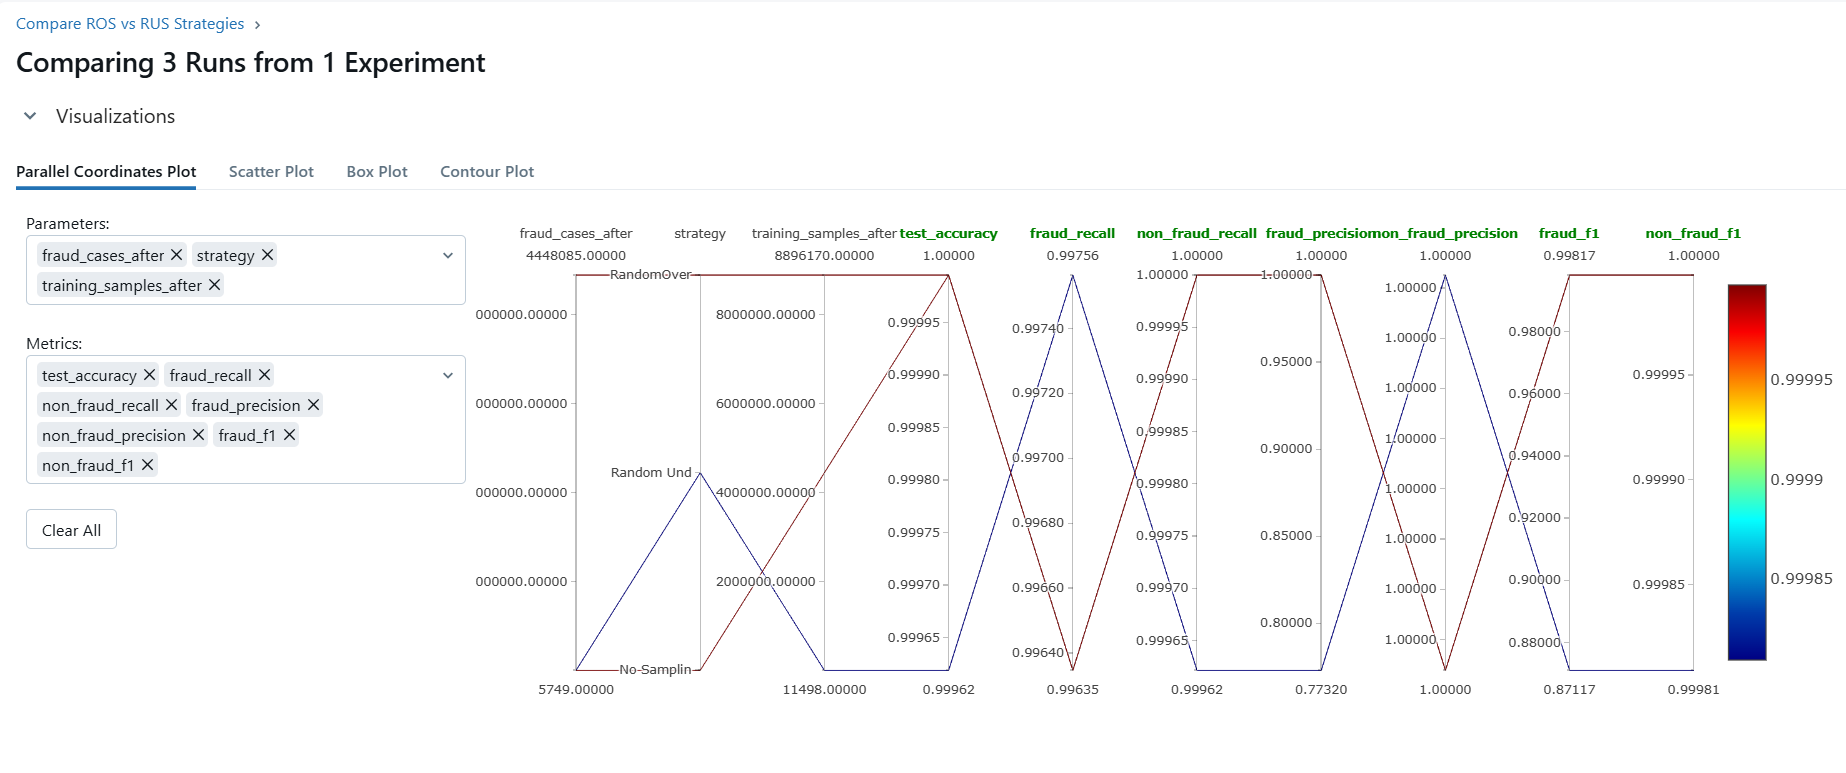

- All three strategies achieve very high performance (above 0.999 in accuracy and 0.997 in fraud recall).

- ROS has the advantage of having the highest accuracy and perfect non_fraud_recall and precisions, but the fraud_recall is slightly lower than RUS.

- RUS has the highest fraud_recall (0.99770) but at the cost of slightly lower accuracy and non_fraud_recall.

- No Sampling has the second highest accuracy and the lowest fraud_recall.

In [ ]:
def plot_strategy_comparison(comparison_df):
    """
    Create visual comparisons of different strategies
    """
    # plt.figure(figsize=(15, 8))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    metrics_to_plot = ['Fraud Precision', 'Fraud Recall', 'Fraud F1-Score', 
                      'False Positive Rate', 'False Negative Rate', 'ROC-AUC']
    
    for i, metric in enumerate(metrics_to_plot, 0):
        ax = axes[i]
        # plt.subplot(3, 3, i)
        bars = ax.bar(comparison_df['Strategy'], comparison_df[metric])
        ax.set_title(f'{metric} by Strategy')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x',rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, comparison_df[metric]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('assets/imbalance_strategy_comparison.png', dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
plot_strategy_comparison(comparison_df)